## Imports

In [1]:
import librosa
import numpy as np
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Data preparation

In [2]:
target_sr = 16000

def parse_time(time_str):
    dt = datetime.strptime(time_str, "%Y-%m-%d_%H-%M-%S-%f")
    # Convert to total seconds since the start of the day
    total_seconds = dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond / 1e6
    return dt, total_seconds  # Return both datetime object and total seconds

def segment_audio(file_path, label_file):
    y, sr = librosa.load(file_path, sr=None)
    y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    with open(label_file, 'r') as f:
        lines = f.readlines()
    
    labels = []
    for line in lines[1:]:
        if(" | " not in line):
            continue
        time_str, position = line.strip().split(' | ')
        dt, total_seconds = parse_time(time_str)
        labels.append([dt, total_seconds, float(position)])
    labels = np.array(labels)
    
    times = labels[:, 1]  # Total seconds since midnight
    dates = labels[:, 0]  # Datetime objects
    positions = labels[:, 2]  # Positions
    
    segments_with_speed = []
    cursor = 0  # Start at the beginning of the audio file
    
    deltaTime = 1
    imax = len(times) - 1
    while(imax % deltaTime != 0 ):
        imax = imax - 1
    for i in range(0, imax, deltaTime):
        start_time = times[i]
        end_time = times[i + deltaTime]
        start_date = dates[i]
        end_date = dates[i + deltaTime]
        
        # Check for day change
        if end_date.date() > start_date.date():
            segment_length = (86400 - start_time) + end_time  # 86400 seconds in a day
        else:
            segment_length = end_time - start_time
        
        end_sample = cursor + int(segment_length * target_sr)
        
        if cursor >= end_sample or segment_length < 0.1:
            print(f"Warning: Empty or realy small segment detected. Cursor: {cursor}, End: {end_sample}")
            continue
        
        segment = y[cursor:end_sample]
        speed = (positions[i+deltaTime] - positions[i]) / segment_length
        
        #Text file longer than audio file trigger this or sometime last segment is too small
        if(len(segment) == 0 or segment.shape[0] < deltaTime*1740):
            continue

        segments_with_speed.append((segment, speed))
        
        cursor = end_sample  # Move cursor to the start of the next segment
    
    return segments_with_speed

def extract_audio_features(segments):
    features = []
    for segment in segments:
        # Convert to mono if necessary
        if segment.ndim > 1:
            segment = librosa.to_mono(segment)
        

        mfccs = librosa.feature.mfcc(y=segment, sr=target_sr, n_mfcc=13, n_fft=1024)
        #print(mfccs.shape)
        mfcc_mean = np.mean(mfccs, axis=1)
        #print(mfcc_mean.shape)

        spectral_centroid = librosa.feature.spectral_centroid(y=segment, sr=target_sr, n_fft=1024)    
        #print(spectral_centroid)
        spectral_centroid_mean = np.mean(spectral_centroid, axis=1)
        #print(spectral_centroid_mean.shape)

        rms = librosa.feature.rms(y=segment)
        rms_mean = np.mean(rms, axis=1)
        #print(rms_mean.shape)

        #mel_spec = librosa.feature.melspectrogram(y=segment, sr=target_sr, n_fft=1024)
        #mel_spec_mean = np.mean(mel_spec, axis=1)
        #print(mel_spec_mean.shape)

        # Combine features for this segment
        segment_features = np.hstack((mfcc_mean, spectral_centroid_mean,rms_mean)) #, mel_spec_mean
        features.append(segment_features)

    #Normalize features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    return np.array(normalized_features)

def normalize_speed(speeds):
    """
    Normalize speeds where 0 speed is 0 and 150 inch-minutes is 1.
    
    :param speeds: List or array of speeds in inch-minutes
    :return: Normalized speeds between 0 and 1
    """
    max_speed = max(speeds)  # Maximum speed in your dataset
    min_speed = 0    # Minimum speed in your dataset
    
    # Ensure speeds are numpy array for vectorized operations
    speeds = np.array(speeds)
    
    # Normalize speeds
    normalized_speeds = np.clip(speeds / max_speed, 0, 1)
    
    return normalized_speeds

In [3]:
directory = "DataSP/Test/"
segments_and_speed = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    # Check if the file is a .wav file
    if filename.endswith(".wav"):
        # Construct the full file path
        filepath = os.path.join(directory, filename)
        segments_and_speed.extend(segment_audio(filepath, filepath[:-3] + "txt"))

In [ ]:

segments, speeds = zip(*segments_and_speed)
#truncate the segments so that they all have the same shape
min_len = min(len(segment) for segment in segments)
print(min_len)
truncated_segments = [segment[:min_len] for segment in segments]

npSegments = np.vstack(truncated_segments)
# Calculate the absolute maximum value across all segments
max_val = np.max(np.abs(npSegments))

# Normalize by dividing by the maximum value
normalized_segments = npSegments / max_val

#Extract features
normalized_audio_features = extract_audio_features(normalized_segments)
normalized_audio_features = np.squeeze(normalized_audio_features)

#PCA had a realy bad effect on the results
#Apply PCA to keep only the best features
#pca = PCA(n_components=0.90)
#pca_features = pca.fit_transform(normalized_audio_features)

# You can check how many components were actually used
#n_components = pca.n_components_
#print(f"Number of components to explain 90% variance: {n_components} out of {normalized_audio_features.shape[1]}")

# Convert speeds to numpy array for consistency with features
speeds = np.array(speeds)

#normalize speed
normalized_speeds = normalize_speed(speeds)

# Ensure features and labels are aligned
#assert len(audio_features) == len(normalized_speeds), "Mismatch in feature and label counts"

X_train, X_test, y_train, y_test = train_test_split(normalized_audio_features, normalized_speeds, test_size=0.2, random_state=42)

1743


## Model, training and testing

In [5]:
class KernelLogisticRegression(BaseEstimator, RegressorMixin):
    def __init__(self, kernel="rbf",C=1.0, max_iter=1000, n_components=1000, gamma=None, learning_rate=0.01):
        self.kernel = kernel
        self.C = C
        self.max_iter = max_iter
        self.n_components = n_components
        self.gamma = gamma
        self.alpha = None
        self.rbf_feature = None,
        self.learning_rate = learning_rate
        #self.classes_ = np.array([0])  # or any dummy value

    def stable_logistic(self, x):
        if isinstance(x, np.ndarray):
            # Using np.where to choose the most numerically stable form
            return np.where(x > 0, 
                            1 / (1 + np.exp(-x)),  # For positive x
                            np.exp(x) / (1 + np.exp(x)))  # For negative or zero x
        else:
            if x > 0:
                return 1 / (1 + np.exp(-x))
            else:
                return np.exp(x) / (1 + np.exp(x))   
 

    def fit(self, X, y):
        # Transform X if using RBF kernel
        if self.kernel == "rbf":
            self.rbf_feature = RBFSampler(n_components=self.n_components, gamma=self.gamma, random_state=42)
            X_transformed = self.rbf_feature.fit_transform(X)
        else:  # Linear kernel
            X_transformed = X

        def objective(alpha):
            return mean_squared_error(y, self.stable_logistic(X_transformed.dot(alpha))) + self.C * np.sum(np.abs(alpha))

        def grad(alpha):
            p = self.stable_logistic(X_transformed.dot(alpha))
            return -X_transformed.T.dot(y - p) + self.C * np.sign(alpha)

         # Initialize alpha
        self.alpha = np.zeros(X_transformed.shape[1])

        # Gradient Descent
        for _ in range(self.max_iter):
            grad_value = grad(self.alpha)
            self.alpha -= self.learning_rate * grad_value

        return self

    def predict_proba(self, X):
        if self.kernel == "rbf":
            X_transformed = self.rbf_feature.transform(X)
        else:
            X_transformed = X
        return self.stable_logistic(X_transformed.dot(self.alpha))

    def predict(self, X):
        return self.predict_proba(X)

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [ ]:
#Define the parameter grid including gamma
#param_grid = {
    #'C': [0.1, 1],
    #'n_components': [1750],
    #'gamma': [0.1, 1],   # 'scale' and 'auto' are special values for gamma
    #'kernel' : ['linear']
#}

param_grid = {
    'C': [0.01, 0.1, 1],  # Regularization parameter
    'n_components': [1600,1800,2000], # Number of components for RBFSampler
    'gamma': [0.1, 1, 10]  # Kernel coefficient for 'rbf'
}

model = KernelLogisticRegression()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2,
                                            scoring='neg_mean_squared_error',  # You can change this to other metrics like 'f1', 'roc_auc', etc.
                                            n_jobs=-1,
                                            error_score='raise',
                                            verbose=2
)
print(X_train.shape)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

(157257, 15)
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[CV] END ..................C=0.1, gamma=1, n_components=1800; total time= 2.9min
[CV] END ..................C=0.1, gamma=1, n_components=1800; total time= 2.9min


In [7]:
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'C': 0.1, 'gamma': 1, 'n_components': 1800}


## Validation

Mean Absolute Error: 0.14252819739218098
Mean Squared Error: 0.03657081398359415
Root Mean Squared Error: 0.19123497060839617
R-squared Score: 0.47841502488755605
Median Absolute Error: 0.1050989498846778


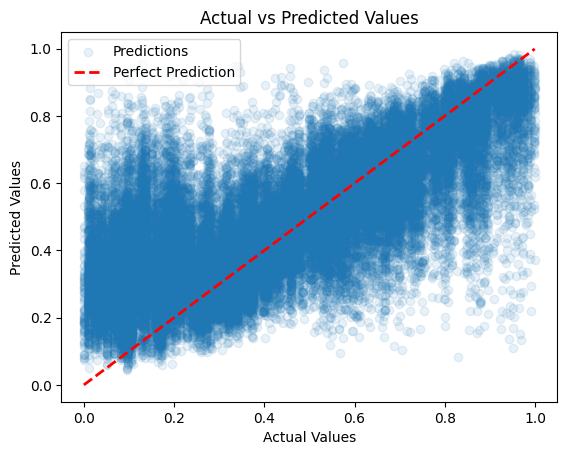

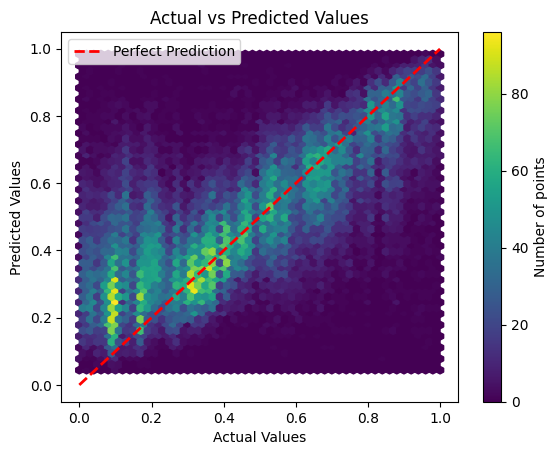

In [8]:
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared Score: {r2}')

#epsilon = 1e-15  # A very small number
#mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100
#print(f'Mean Absolute Percentage Error: {mape}%')

medae = np.median(np.abs(y_test - y_pred))
print(f'Median Absolute Error: {medae}')

plt.scatter(y_test, y_pred, label='Predictions', alpha=0.1)

#hb = plt.hexbin(y_test, y_pred, gridsize=50, cmap='viridis')
#plt.colorbar(hb, label='Number of points')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")

# Add legend
plt.legend(loc='upper left')

# Ensure the axes are equal for a better visual comparison
#plt.axis('equal')

plt.show()


hb = plt.hexbin(y_test, y_pred, gridsize=50, cmap='viridis')
plt.colorbar(hb, label='Number of points')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")

# Add legend
plt.legend(loc='upper left')

# Ensure the axes are equal for a better visual comparison
#plt.axis('equal')

plt.show()